In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr, fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import seaborn as sns
from skbio.stats.composition import clr

sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Correlate proteomics data with median titers
##### 7/18/22
##### Michael Shaffer
##### Merck ESC, Sys bio group

After some success with KOs and more success with metabolomics we decided to go into proteomics. Same exact approach as in metabolomics.

## Read in the data

This is a data sheet that I got directly from Hendrik.

In [2]:
raw_proteomics = pd.read_csv('../../data/proteomics_abunds.txt', sep='\t', index_col=0).transpose()
raw_proteomics.head()

,BioID,Well,Run Number,Hospital,VisitID,Age,Draw,Matrix,Draw_Matrix,Draw_Matrix_Time,...,sp|Q6UWP8|SBSN_HUMAN,sp|Q6UXB8|PI16_HUMAN,sp|Q92736|RYR2_HUMAN,sp|Q96IY4|CBPB2_HUMAN,sp|Q96PD5|PGRP2_HUMAN,sp|Q9HDC9|APMAP_HUMAN,sp|Q9NZP8|C1RL_HUMAN,sp|Q9UBP9|GULP1_HUMAN,sp|Q9UGM5|FETUB_HUMAN,sp|Q9Y490|TLN1_HUMAN
LFQ intensity 005_HFX_HW_RAW_IMC_A1_106A,106A,A1,5,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,18.2125721,23.48308372,20.45380974,21.819561,25.08229065,20.85553551,20.4588604,28.83514977,21.02322769,20.34404564
LFQ intensity 006_HFX_HW_RAW_IMC_A2_209A,209A,A2,6,Well Check 02m,V5,55,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,16.90970612,23.31561852,18.60210037,22.21127701,24.88887978,20.59141159,17.14304733,28.68237686,21.82271576,19.7013855
LFQ intensity 012_HFX_HW_RAW_IMC_A8_214A,214A,A8,12,Well Check 02m,V5,89,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,13.34554386,23.58817863,18.65951729,21.8640461,25.16353798,21.04162788,18.74650764,29.10836601,19.95448685,20.4085598
LFQ intensity 021_HFX_HW_RAW_IMC_C3_227A,227A,C3,21,Well Check 02m,V5,57,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,20.80704689,23.25824928,21.18655968,21.24667168,25.07989311,19.46746445,20.6216526,28.35871315,20.65556526,20.66396141
LFQ intensity 024_HFX_HW_RAW_IMC_C6_124A,124A,C6,24,Well Check 02m,V5,97,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,17.50129318,23.05339622,21.60560417,21.72242355,25.20258331,19.91134644,21.13340378,28.25678444,20.77088356,20.50154495


This is removing all columns that doen't have abundance information, taking only unique ID from row names and converting to floats.

In [3]:
proteomics = raw_proteomics.loc[[i for i in raw_proteomics.index if i.startswith('LFQ intensity')],
                                raw_proteomics.columns[list(raw_proteomics.columns).index('Subject ID')+1:]]
proteomics.index = [i.split()[-1] for i in proteomics.index]
proteomics = proteomics.astype(float)
proteomics.head()

,CON__P00761,sp|P02533|K1C14_HUMAN;CON__P02533,sp|P02768|ALBU_HUMAN;CON__P02768-1,CON__P02769,sp|P48668|K2C6C_HUMAN;CON__P48668;CON__P04259,sp|P13645|K1C10_HUMAN;CON__P13645,sp|P13647|K2C5_HUMAN;CON__P13647,CON__P35908;CON__P35908v2;sp|P35908|K22E_HUMAN,sp|Q86YZ3|HORN_HUMAN;CON__Q86YZ3,sp|A0A075B6H9|LV469_HUMAN,...,sp|Q6UWP8|SBSN_HUMAN,sp|Q6UXB8|PI16_HUMAN,sp|Q92736|RYR2_HUMAN,sp|Q96IY4|CBPB2_HUMAN,sp|Q96PD5|PGRP2_HUMAN,sp|Q9HDC9|APMAP_HUMAN,sp|Q9NZP8|C1RL_HUMAN,sp|Q9UBP9|GULP1_HUMAN,sp|Q9UGM5|FETUB_HUMAN,sp|Q9Y490|TLN1_HUMAN
005_HFX_HW_RAW_IMC_A1_106A,29.414034,19.480482,33.365807,23.197741,21.572432,21.094681,19.310707,19.288029,19.483946,21.265715,...,18.212572,23.483084,20.453810,21.819561,25.082291,20.855536,20.458860,28.835150,21.023228,20.344046
006_HFX_HW_RAW_IMC_A2_209A,29.336454,19.774490,32.956917,23.397673,21.685078,22.188005,20.725851,20.871471,19.841579,20.858858,...,16.909706,23.315619,18.602100,22.211277,24.888880,20.591412,17.143047,28.682377,21.822716,19.701386
012_HFX_HW_RAW_IMC_A8_214A,28.906614,19.529310,33.174339,24.401390,19.594507,22.131947,19.528219,20.954256,18.534006,21.559875,...,13.345544,23.588179,18.659517,21.864046,25.163538,21.041628,18.746508,29.108366,19.954487,20.408560
021_HFX_HW_RAW_IMC_C3_227A,29.769306,21.061234,33.328308,24.742115,20.643036,20.368902,20.235897,17.218355,19.047693,21.543921,...,20.807047,23.258249,21.186560,21.246672,25.079893,19.467464,20.621653,28.358713,20.655565,20.663961
024_HFX_HW_RAW_IMC_C6_124A,29.567360,20.363079,32.930107,23.502518,20.780497,19.634420,20.836931,17.906363,18.741560,22.351000,...,17.501293,23.053396,21.605604,21.722424,25.202583,19.911346,21.133404,28.256784,20.770884,20.501545


In [4]:
print(len(proteomics.columns))

250


250 proteins measured.

Convert the abundances to relative abundance for comparison of normalizations.

In [5]:
proteomics_rel = proteomics.div(proteomics.sum(axis=1), axis=0)
proteomics_rel.head()

,CON__P00761,sp|P02533|K1C14_HUMAN;CON__P02533,sp|P02768|ALBU_HUMAN;CON__P02768-1,CON__P02769,sp|P48668|K2C6C_HUMAN;CON__P48668;CON__P04259,sp|P13645|K1C10_HUMAN;CON__P13645,sp|P13647|K2C5_HUMAN;CON__P13647,CON__P35908;CON__P35908v2;sp|P35908|K22E_HUMAN,sp|Q86YZ3|HORN_HUMAN;CON__Q86YZ3,sp|A0A075B6H9|LV469_HUMAN,...,sp|Q6UWP8|SBSN_HUMAN,sp|Q6UXB8|PI16_HUMAN,sp|Q92736|RYR2_HUMAN,sp|Q96IY4|CBPB2_HUMAN,sp|Q96PD5|PGRP2_HUMAN,sp|Q9HDC9|APMAP_HUMAN,sp|Q9NZP8|C1RL_HUMAN,sp|Q9UBP9|GULP1_HUMAN,sp|Q9UGM5|FETUB_HUMAN,sp|Q9Y490|TLN1_HUMAN
005_HFX_HW_RAW_IMC_A1_106A,0.005043,0.003340,0.005721,0.003977,0.003699,0.003617,0.003311,0.003307,0.003341,0.003646,...,0.003123,0.004026,0.003507,0.003741,0.004301,0.003576,0.003508,0.004944,0.003605,0.003488
006_HFX_HW_RAW_IMC_A2_209A,0.005066,0.003415,0.005691,0.004041,0.003745,0.003832,0.003579,0.003604,0.003426,0.003602,...,0.002920,0.004026,0.003212,0.003836,0.004298,0.003556,0.002960,0.004953,0.003769,0.003402
012_HFX_HW_RAW_IMC_A8_214A,0.005009,0.003384,0.005749,0.004229,0.003396,0.003835,0.003384,0.003631,0.003212,0.003736,...,0.002313,0.004088,0.003234,0.003789,0.004361,0.003646,0.003249,0.005044,0.003458,0.003537
021_HFX_HW_RAW_IMC_C3_227A,0.005104,0.003611,0.005715,0.004242,0.003540,0.003493,0.003470,0.002952,0.003266,0.003694,...,0.003568,0.003988,0.003633,0.003643,0.004300,0.003338,0.003536,0.004862,0.003542,0.003543
024_HFX_HW_RAW_IMC_C6_124A,0.005069,0.003491,0.005646,0.004030,0.003563,0.003366,0.003573,0.003070,0.003213,0.003832,...,0.003001,0.003953,0.003704,0.003724,0.004321,0.003414,0.003623,0.004845,0.003561,0.003515


Same thing but with CLR.

In [6]:
proteomics_clr = pd.DataFrame(clr(proteomics + .001), index=proteomics.index, columns=proteomics.columns)
proteomics_clr.head()

,CON__P00761,sp|P02533|K1C14_HUMAN;CON__P02533,sp|P02768|ALBU_HUMAN;CON__P02768-1,CON__P02769,sp|P48668|K2C6C_HUMAN;CON__P48668;CON__P04259,sp|P13645|K1C10_HUMAN;CON__P13645,sp|P13647|K2C5_HUMAN;CON__P13647,CON__P35908;CON__P35908v2;sp|P35908|K22E_HUMAN,sp|Q86YZ3|HORN_HUMAN;CON__Q86YZ3,sp|A0A075B6H9|LV469_HUMAN,...,sp|Q6UWP8|SBSN_HUMAN,sp|Q6UXB8|PI16_HUMAN,sp|Q92736|RYR2_HUMAN,sp|Q96IY4|CBPB2_HUMAN,sp|Q96PD5|PGRP2_HUMAN,sp|Q9HDC9|APMAP_HUMAN,sp|Q9NZP8|C1RL_HUMAN,sp|Q9UBP9|GULP1_HUMAN,sp|Q9UGM5|FETUB_HUMAN,sp|Q9Y490|TLN1_HUMAN
005_HFX_HW_RAW_IMC_A1_106A,0.239511,-0.172531,0.365567,0.002103,-0.070532,-0.092927,-0.181283,-0.182458,-0.172353,-0.084852,...,-0.239828,0.014328,-0.123777,-0.059142,0.080207,-0.104328,-0.123530,0.219635,-0.096319,-0.129157
006_HFX_HW_RAW_IMC_A2_209A,0.244758,-0.149664,0.361124,0.018572,-0.057437,-0.034510,-0.102677,-0.095676,-0.146277,-0.096280,...,-0.306160,0.015059,-0.210779,-0.033462,0.080354,-0.109184,-0.292456,0.222211,-0.051110,-0.153367
012_HFX_HW_RAW_IMC_A8_214A,0.234427,-0.157710,0.372129,0.065003,-0.154378,-0.032611,-0.157766,-0.087288,-0.210017,-0.058797,...,-0.538420,0.031110,-0.203268,-0.044789,0.095758,-0.083128,-0.198617,0.241382,-0.136174,-0.113674
021_HFX_HW_RAW_IMC_C3_227A,0.251985,-0.094045,0.364910,0.067021,-0.114100,-0.127468,-0.134019,-0.295493,-0.194528,-0.071387,...,-0.106187,0.005176,-0.088113,-0.085279,0.080580,-0.172731,-0.115137,0.203443,-0.113494,-0.113087
024_HFX_HW_RAW_IMC_C6_124A,0.245111,-0.127821,0.352824,0.015557,-0.107531,-0.164258,-0.104819,-0.256382,-0.210797,-0.034678,...,-0.279262,-0.003737,-0.068595,-0.063202,0.085393,-0.150254,-0.090691,0.199775,-0.107993,-0.121045


Now we will pull the metadata from the non-abundance columns.

In [7]:
meta_base = raw_proteomics.loc[[i for i in raw_proteomics.index if i.startswith('LFQ intensity')],
                               raw_proteomics.columns[:list(raw_proteomics.columns).index('Subject ID')+1]]
meta_base.index = [i.split()[-1] for i in meta_base.index]
column_name_replacements = {'Subject ID': 'BabyN', 'VisitID': 'VisitCode'}
meta_base.columns = [i if i not in column_name_replacements else column_name_replacements[i] for i in meta_base.columns]
meta_base['BabyN'] = [int(i) for i in meta_base['BabyN']]
meta_base.head()

,BioID,Well,Run Number,Hospital,VisitCode,Age,Draw,Matrix,Draw_Matrix,Draw_Matrix_Time,Plate,Responder Status,Group_ID,Group_ID_Responder,Responder Status NVRHVR,Group_ID_Responder2Groups,BabyN
005_HFX_HW_RAW_IMC_A1_106A,106A,A1,5,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,LVR,V5_Heelstick_Serum_LVR,V5_Heelstick_Serum_LVR,NVR,V5_Heelstick_Serum_NVR,106
006_HFX_HW_RAW_IMC_A2_209A,209A,A2,6,Well Check 02m,V5,55,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,NVR,V5_Heelstick_Serum_NVR,V5_Heelstick_Serum_NVR,NVR,V5_Heelstick_Serum_NVR,209
012_HFX_HW_RAW_IMC_A8_214A,214A,A8,12,Well Check 02m,V5,89,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,HVR,V5_Heelstick_Serum_HVR,V5_Heelstick_Serum_HVR,HVR,V5_Heelstick_Serum_HVR,214
021_HFX_HW_RAW_IMC_C3_227A,227A,C3,21,Well Check 02m,V5,57,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,HVR,V5_Heelstick_Serum_HVR,V5_Heelstick_Serum_HVR,HVR,V5_Heelstick_Serum_HVR,226
024_HFX_HW_RAW_IMC_C6_124A,124A,C6,24,Well Check 02m,V5,97,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,1,NaN,V5_Heelstick_Serum_NA,V5_Heelstick_Serum_NA,NaN,V5_Heelstick_Serum_NA,124


Bring in titer data.

In [8]:
titer_data = pd.read_csv('../../data/vaccine_response/vaccine_response_y1.tsv', sep='\t', index_col=0)
titer_data.index = [int(i.split('Baby')[-1]) for i in titer_data.index]
titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
106,2.5,0.21,11.0,2.5,0.30,0.39,141.0,35.0,56.0,139.0,...,0.061955,0.052874,0.061955,False,True,True,False,True,True,NVR
107,2.5,0.44,3.0,9.0,0.52,1.60,2430.0,415.0,194.0,332.0,...,0.449483,0.114018,0.958142,False,True,False,True,True,True,NVR
108,2.5,0.05,1.5,2.5,0.05,0.27,21.0,3.0,24.0,41.0,...,0.000000,0.000000,0.003102,False,False,False,False,False,True,LVR
109,27.0,NaN,NaN,63.0,1.35,7.02,NaN,NaN,NaN,NaN,...,0.700925,0.763049,0.486810,True,False,False,True,True,True,NVR
110,14.0,0.24,15.0,20.0,2.45,NaN,301.0,63.0,400.0,289.0,...,0.266219,0.284211,0.245121,True,True,True,True,True,False,NVR


Split titer data to be per sample that we have in the proteomics metadata.

In [9]:
per_sample_titer_data = pd.DataFrame({sample: titer_data.loc[i] for sample, i in meta_base['BabyN'].iteritems() if i in titer_data.index}).transpose()
per_sample_titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
005_HFX_HW_RAW_IMC_A1_106A,2.5,0.21,11.0,2.5,0.3,0.39,141.0,35.0,56.0,139.0,...,0.061955,0.052874,0.061955,False,True,True,False,True,True,NVR
006_HFX_HW_RAW_IMC_A2_209A,5.0,0.29,7.0,5.0,0.27,1.17,154.0,40.0,89.0,679.0,...,0.102041,0.105087,0.074972,False,True,False,False,True,True,NVR
012_HFX_HW_RAW_IMC_A8_214A,12.0,0.28,29.0,19.0,0.66,4.7,NaN,NaN,NaN,NaN,...,0.310899,0.310899,NaN,True,True,True,True,True,True,NVR
021_HFX_HW_RAW_IMC_C3_227A,6.0,0.25,11.0,20.0,0.82,2.25,381.0,94.0,90.0,322.0,...,0.191269,0.205742,0.139576,False,True,True,True,True,True,NVR
026_HFX_HW_RAW_IMC_C8_208A,6.0,0.32,9.0,2.5,0.14,0.91,297.0,193.0,181.0,278.0,...,0.125416,0.113055,0.125416,False,True,True,False,True,True,NVR


Merge proteomics metadata and titer data. Remove samples without a VR group.

In [10]:
meta = pd.concat([meta_base, per_sample_titer_data], axis=1)
meta = meta.loc[~pd.isna(meta['VR_group'])]
meta.head()

,BioID,Well,Run Number,Hospital,VisitCode,Age,Draw,Matrix,Draw_Matrix,Draw_Matrix_Time,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
005_HFX_HW_RAW_IMC_A1_106A,106A,A1,5,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,0.061955,0.052874,0.061955,False,True,True,False,True,True,NVR
006_HFX_HW_RAW_IMC_A2_209A,209A,A2,6,Well Check 02m,V5,55,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,0.102041,0.105087,0.074972,False,True,False,False,True,True,NVR
012_HFX_HW_RAW_IMC_A8_214A,214A,A8,12,Well Check 02m,V5,89,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,0.310899,0.310899,NaN,True,True,True,True,True,True,NVR
021_HFX_HW_RAW_IMC_C3_227A,227A,C3,21,Well Check 02m,V5,57,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,0.191269,0.205742,0.139576,False,True,True,True,True,True,NVR
026_HFX_HW_RAW_IMC_C8_208A,208A,C8,26,Well Check 02m,V5,63,Heelstick,Serum,Heelstick_Serum,V5_Heelstick_Serum,...,0.125416,0.113055,0.125416,False,True,True,False,True,True,NVR


In [11]:
in_both = list(set(meta.index) & set(proteomics.index))
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(47, 65)


In [12]:
meta_matched['VisitCode'].value_counts()

V5    45
V6     2
Name: VisitCode, dtype: int64

47 samples are in the metadata and proteomics data. Of those two are V6. We will filter those out.

In [13]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")

## Do correlation with un-normalized data

We will do our correlations between proteomics and median titer. I used Spearman correlation and Benjamini-Hochberg for FDR correction per set of tests.

In [14]:
proteomics_v5 = proteomics.loc[meta_v5.index]
v5_correlations = proteomics_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head(15)

,rho,p_value,p_adj
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.518353,0.000265,0.066211
sp|P68871|HBB_HUMAN,-0.472685,0.001043,0.087363
sp|P69905|HBA_HUMAN,-0.472488,0.001048,0.087363
sp|O75636|FCN3_HUMAN,0.461417,0.001421,0.088834
sp|P08697|A2AP_HUMAN,-0.395980,0.007089,0.316359
sp|P02042|HBD_HUMAN,-0.392883,0.007593,0.316359
sp|A0A075B6S2|KVD29_HUMAN;sp|A2NJV5|KV229_HUMAN;sp|A0A0A0MRZ7|KVD26_HUMAN,-0.356046,0.016374,0.486481
sp|P69891|HBG1_HUMAN,-0.355980,0.016395,0.486481
sp|P05156|CFAI_HUMAN,0.352619,0.017513,0.486481
sp|P0DP02|HVC33_HUMAN,-0.347084,0.019495,0.487375


No significant results after FDR correction.

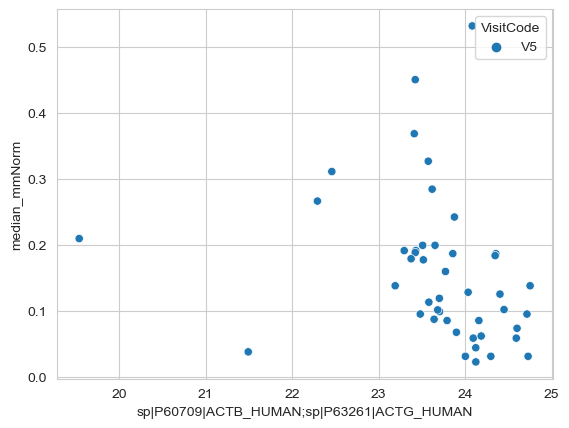

In [15]:
_ =sns.scatterplot(x='sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN', y='median_mmNorm', hue='VisitCode',
                   data=pd.concat([proteomics.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V5'"))

This is our best result at a p-value of .06 and R value of -.51. Not super compelling.

## Relative abunds

Let's try different normalizations to see how that effects the results. I will start with relative abundances.

In [16]:
proteomics_rel_v5 = proteomics_rel.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_rel = proteomics_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_rel.columns = ['rho', 'p_value']
v5_correlations_rel['p_adj'] = p_adjust(v5_correlations_rel['p_value'])
v5_correlations_rel = v5_correlations_rel.sort_values('p_value')
v5_correlations_rel.head()

,rho,p_value,p_adj
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.497661,0.000505,0.126146
sp|P69905|HBA_HUMAN,-0.464185,0.001318,0.164807
sp|P68871|HBB_HUMAN,-0.445140,0.002184,0.181999
sp|P02042|HBD_HUMAN,-0.408237,0.005371,0.298029
sp|O75636|FCN3_HUMAN,0.403690,0.005961,0.298029


Even worse p-values.

## CLR

In [17]:
proteomics_clr_v5 = proteomics_clr.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_clr = proteomics_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_clr.columns = ['rho', 'p_value']
v5_correlations_clr['p_adj'] = p_adjust(v5_correlations_clr['p_value'])
v5_correlations_clr = v5_correlations_clr.sort_values('p_value')
v5_correlations_clr.head()

,rho,p_value,p_adj
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.494036,0.000563,0.140640
sp|P69905|HBA_HUMAN,-0.458979,0.001518,0.189731
sp|P68871|HBB_HUMAN,-0.435453,0.002793,0.232731
sp|P02042|HBD_HUMAN,-0.407908,0.005412,0.294914
sp|O75636|FCN3_HUMAN,0.404152,0.005898,0.294914


Even worse p-values than relative abundance normalization.

## Do correlations with separated titers

Now we will see if spliting titers gives better results.

In [18]:
v5_DTAPHib_correlations = proteomics_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
CON__P00761,-0.430200,0.003182,0.399812
sp|P05156|CFAI_HUMAN,0.409966,0.005160,0.399812
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.391972,0.007746,0.399812
sp|P69905|HBA_HUMAN,-0.387292,0.008579,0.399812
sp|Q03591|FHR1_HUMAN,0.382151,0.009582,0.399812


The least significant p-values so far.

In [19]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]

In [20]:
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
proteomics_PCV_v5 = proteomics.loc[meta_PCV_v5.index]
v5_PCV_correlations = proteomics_PCV_v5.apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
sp|O75636|FCN3_HUMAN,0.522293,0.000388,0.097082
sp|P68871|HBB_HUMAN,-0.464170,0.001959,0.169388
sp|P69905|HBA_HUMAN,-0.462711,0.002033,0.169388
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.423638,0.005180,0.230468
sp|P10643|CO7_HUMAN,0.423071,0.005247,0.230468


A adjusted p-value < .1 result but still all insignificant.

### Relative abundance

We will check the other adjustments as well.

In [21]:
v5_DTAPHib_correlations_rel = proteomics_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_rel.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_rel['p_adj'] = p_adjust(v5_DTAPHib_correlations_rel['p_value'])
v5_DTAPHib_correlations_rel = v5_DTAPHib_correlations_rel.sort_values('p_value')
v5_DTAPHib_correlations_rel.head()

,rho,p_value,p_adj
sp|Q03591|FHR1_HUMAN,0.392631,0.007635,0.565246
sp|P05156|CFAI_HUMAN,0.390720,0.007962,0.565246
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.383404,0.009329,0.565246
sp|P69905|HBA_HUMAN,-0.377669,0.010537,0.565246
sp|P02042|HBD_HUMAN,-0.365608,0.013522,0.565246


In [22]:
proteomics_rel_PCV_v5 = proteomics_rel.loc[meta_PCV_v5.index]
v5_PCV_correlations_rel = proteomics_rel_PCV_v5.apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_rel.columns = ['rho', 'p_value']
v5_PCV_correlations_rel['p_adj'] = p_adjust(v5_PCV_correlations_rel['p_value'])
v5_PCV_correlations_rel = v5_PCV_correlations_rel.sort_values('p_value')
v5_PCV_correlations_rel.head()

,rho,p_value,p_adj
sp|O75636|FCN3_HUMAN,0.464332,0.001951,0.209628
sp|P69905|HBA_HUMAN,-0.463440,0.001995,0.209628
sp|P68871|HBB_HUMAN,-0.454199,0.002516,0.209628
sp|P10643|CO7_HUMAN,0.405399,0.007735,0.477508
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.388457,0.011015,0.477508


Nothing is significant for either titer.

### CLR

In [23]:
v5_DTAPHib_correlations_clr = proteomics_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_clr.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_clr['p_adj'] = p_adjust(v5_DTAPHib_correlations_clr['p_value'])
v5_DTAPHib_correlations_clr = v5_DTAPHib_correlations_clr.sort_values('p_value')
v5_DTAPHib_correlations_clr.head()

,rho,p_value,p_adj
sp|Q03591|FHR1_HUMAN,0.389204,0.008230,0.60381
sp|P05156|CFAI_HUMAN,0.384195,0.009172,0.60381
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.380174,0.009994,0.60381
sp|P69905|HBA_HUMAN,-0.376417,0.010818,0.60381
sp|P02743|SAMP_HUMAN,0.365937,0.013432,0.60381


In [24]:
proteomics_clr_PCV_v5 = proteomics_clr.loc[meta_PCV_v5.index]
v5_PCV_correlations_clr = proteomics_clr_PCV_v5.apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_clr.columns = ['rho', 'p_value']
v5_PCV_correlations_clr['p_adj'] = p_adjust(v5_PCV_correlations_clr['p_value'])
v5_PCV_correlations_clr = v5_PCV_correlations_clr.sort_values('p_value')
v5_PCV_correlations_clr.head()

,rho,p_value,p_adj
sp|O75636|FCN3_HUMAN,0.465872,0.001875,0.247371
sp|P69905|HBA_HUMAN,-0.463765,0.001979,0.247371
sp|P68871|HBB_HUMAN,-0.445201,0.003133,0.261087
sp|P10643|CO7_HUMAN,0.395833,0.009464,0.481363
sp|P60709|ACTB_HUMAN;sp|P63261|ACTG_HUMAN,-0.386592,0.011440,0.481363


 Again nothing with CLR.